In [1]:
#!/usr/bin/env python3
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import tinydb as db
from tinydb.storages import MemoryStorage
import matplotlib.pyplot as plt
# plt.style.use('../clint.mpl')
from matplotlib.colors import LogNorm

from pygama import DataGroup
import pygama.io.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf

Load data from the run of interest

In [2]:
dg = DataGroup('cage.json', load=True)
run = 'run==31'
dg.file_keys.query(run, inplace=True)
view_cols = ['runtype', 'run', 'cycle', 'startTime', 'runtime', 'threshold']
print(dg.file_keys[view_cols])

Loading file key list from: ./fileDB.h5
     runtype  run  cycle     startTime    runtime  threshold
528  oppi_v2   31    531  1.599257e+09  29.987254        8.0
529  oppi_v2   31    532  1.599259e+09  29.992105        8.0
530  oppi_v2   31    533  1.599261e+09  29.985067        8.0
531  oppi_v2   31    534  1.599263e+09   7.420690        8.0


Plot raw energy histogram of the data, from DSP files
First get dsp data, runtimes so we can normalize by time

In [ ]:
# get file list and load energy data (numpy array)
lh5_dir = os.path.expandvars(dg.config['lh5_dir'])
dsp_list = lh5_dir + dg.file_keys['dsp_path'] + '/' + dg.file_keys['dsp_file']
edata = lh5.load_nda(dsp_list, ['trapEmax'], 'ORSIS3302DecoderForEnergy/dsp')
rt_min = dg.file_keys['runtime'].sum()
u_start = dg.file_keys.iloc[0]['startTime']
t_start = pd.to_datetime(u_start, unit='s') # str

In [ ]:
# Create histogram, normalized by runtime
elo, ehi, epb = 0, 25000, 10 
etype = 'trapEmax'

ene_uncal = edata[etype]
hist, bins, _ = pgh.get_hist(ene_uncal, range=(elo, ehi), dx=epb)

# normalize by runtime in seconds
hist_rt = np.divide(hist, rt_min * 60)

In [ ]:
# Plot the histogram
plt.semilogy(bins[1:], hist_rt, ds='steps', c='b', lw=1,
            label=f'{etype}, {rt_min:.2f} mins')

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('cts / sec', ha='right', y=1)
plt.legend()
plt.show()

Load hit data from local directory

In [6]:
lh5_dir = dg.lh5_user_dir #if user else dg.lh5_dir
hit_list = lh5_dir + dg.file_keys['hit_path'] + '/' + dg.file_keys['hit_file']
df_hit = lh5.load_dfs(hit_list, ['trapEmax', 'bl','bl_sig','A_10','ts_sec', 'dcr_raw'], 'ORSIS3302DecoderForEnergy/hit')
# print(df_hit)
print(df_hit.columns)

dsc = df_hit[['bl','bl_sig','A_10','ts_sec', 'dcr_raw']].describe()
print(dsc)

Index(['trapEmax', 'bl', 'bl_sig', 'A_10', 'ts_sec', 'dcr_raw'], dtype='object')
                  bl         bl_sig           A_10         ts_sec  \
count  385461.000000  385461.000000  385461.000000  385461.000000   
mean     9079.127930       4.329427      72.080994     847.054185   
std      1507.844116      46.062943     189.287857     530.939624   
min         0.000000       0.000000       1.499873       0.036842   
25%      9282.013672       3.495314      18.107244     365.704441   
50%      9293.638672       3.641525      29.810297     824.257389   
75%      9299.955078       3.878845      59.423962    1310.589926   
max     43856.105469   16691.498047    2933.832031    1799.526282   

            dcr_raw  
count  3.853220e+05  
mean  -5.662786e+31  
std             inf  
min   -1.847577e+36  
25%   -6.598945e+01  
50%   -3.159261e+01  
75%   -1.812286e+01  
max    1.646826e+36  


Now plot baseline vs E

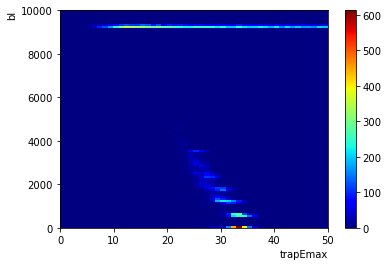

In [8]:
# Baseline vs E
elo, ehi, epb = 0, 50, 1
blo, bhi, bpb = 0, 10000, 100
nbx = int((ehi-elo)/epb)
nby = int((bhi-blo)/bpb)

h = plt.hist2d(df_hit['trapEmax'], df_hit['bl'], bins=[nbx,nby],
                       range=[[elo, ehi], [blo, bhi]], cmap='jet')

cb = plt.colorbar(h[3], ax=plt.gca())
plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('bl', ha='right', y=1)
# plt.tight_layout()
plt.show()

Make a cut based on BL value

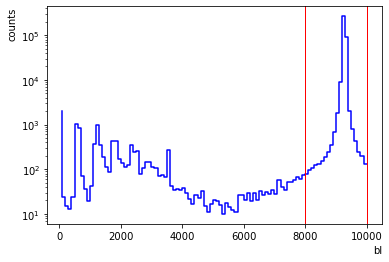

In [10]:
# make a formal baseline cut from 1d histogram
hE, bins, vE = pgh.get_hist(df_hit['bl'], range=(blo, bhi), dx=bpb)
xE = bins[1:]
plt.semilogy(xE, hE, c='b', ds='steps')

bl_cut_lo, bl_cut_hi = 8000,10000
plt.axvline(bl_cut_lo, c='r', lw=1)
plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('bl', ha='right', x=1)
plt.ylabel('counts', ha='right', y=1)
plt.show()

Use BL cut from above, create A/E

In [11]:
# A_10/trapEmax vs trapEmax (A/E vs E)

# use baseline cut
df_cut = df_hit.query('bl > 8000 and bl < 10000').copy()

# add new A/E column
df_cut['aoe'] = df_cut['A_10'] / df_cut['trapEmax']

Plot A/E vs E

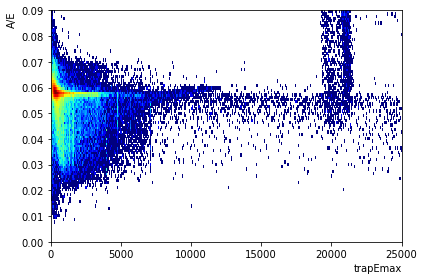

In [12]:
alo, ahi, apb = 0.0, 0.09, 0.0009
elo, ehi, epb = 0, 25000, 10
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)
nby = int((ahi-alo)/apb)

h = plt.hist2d(df_cut['trapEmax'], df_cut['aoe'], bins=[nbx,nby],
                range=[[elo, ehi], [alo, ahi]], cmap='jet', norm=LogNorm())

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('A/E', ha='right', y=1)
plt.tight_layout()
plt.show()

Plot DCR vs E

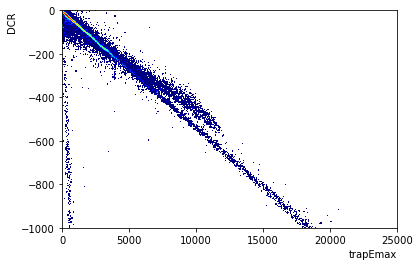

In [47]:
# show DCR vs E
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 25000, 10
#         dlo, dhi, dpb = -1000, 1000, 10
#         dlo, dhi, dpb = -0.25, 0.25, 0.0005
# dlo, dhi, dpb = -10., 10., 0.005
dlo, dhi, dpb = -1000., 0., 1

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

h = plt.hist2d(df_cut['trapEmax'], df_cut['dcr_raw'], bins=[nbx,nby],
                range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm())

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('DCR', ha='right', y=1)
plt.savefig('./plots/alpha_dcr_raw_run31.png', dpi=200)
# plt.tight_layout()
plt.show()

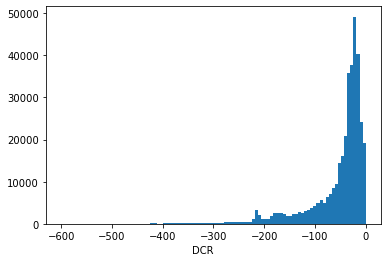

In [32]:
# show DCR vs E
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 25000, 10
#         dlo, dhi, dpb = -1000, 1000, 10
#         dlo, dhi, dpb = -0.25, 0.25, 0.0005
# dlo, dhi, dpb = -10., 10., 0.005
dlo, dhi, dpb = -1000., 0., 1

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)
bins = np.linspace(-600, 0., 100)

h = plt.hist(df_cut['dcr_raw'], bins)

# plt.xlabel('trapEmax', ha='right', x=1)
plt.xlabel('DCR', ha='right', y=1)
# plt.tight_layout()
plt.show()

In [33]:
#create dcr/E
df_cut['dcr_norm'] = df_cut['dcr_raw'] / df_cut['trapEmax']

100


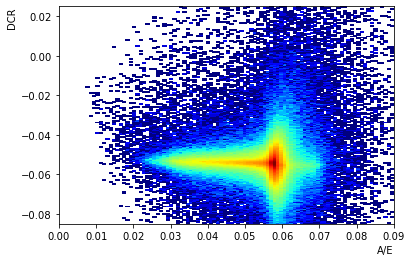

In [68]:
# show DCR vs A/E
alo, ahi, apb = 0.0, 0.09, 0.0009
#         dlo, dhi, dpb = -1000, 1000, 10
#         dlo, dhi, dpb = -0.25, 0.25, 0.0005
dlo, dhi, dpb = -0.085, 0.025, 0.0005
# dlo, dhi, dpb = -1000., 0.8, 1

nbx = int((ahi-alo)/apb)
print(nbx)
nby = int((dhi-dlo)/dpb)

h = plt.hist2d(df_cut['aoe'], df_cut['dcr_norm'], bins=[nbx,nby],
                range=[[alo, ahi], [dlo, dhi]], cmap='jet', norm=LogNorm())

plt.xlabel('A/E', ha='right', x=1)
plt.ylabel('DCR', ha='right', y=1)
# plt.savefig('./plots/zoom_alpha_dcr_norm_run31.png', dpi=200)
# plt.tight_layout()
plt.show()

In [ ]:
# show DCR vs E
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 25000, 10
#         dlo, dhi, dpb = -1000, 1000, 10
#         dlo, dhi, dpb = -0.25, 0.25, 0.0005
dlo, dhi, dpb = -0.075, 0.025, 0.0005
# dlo, dhi, dpb = -1000., 0.8, 1

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

h = plt.hist2d(df_cut['trapEmax'], df_cut['dcr_norm'], bins=[nbx,nby],
                range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm())

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('DCR', ha='right', y=1)
plt.savefig('./plots/zoom_alpha_dcr_norm_run31.png', dpi=200)
# plt.tight_layout()
plt.show()

In [58]:
df_dcr_cut = df_cut.query('trapEmax > 5000 and dcr_norm > 0.05').copy()

In [61]:
energy = df_dcr_cut['trapEmax']
print(len(energy))

3484


In [ ]:
# show DCR vs E
etype = 'trapEmax'
#       elo, ehi, epb = 0, 6000, 10
elo, ehi, epb = 0, 25000, 10
#         dlo, dhi, dpb = -1000, 1000, 10
#         dlo, dhi, dpb = -0.25, 0.25, 0.0005
dlo, dhi, dpb = -0.075, 0.025, 0.0005
# dlo, dhi, dpb = -1000., 0.8, 1

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

h = plt.hist2d(df_dcr_cut['trapEmax'], df_cut['dcr_norm'], bins=[nbx,nby],
                range=[[elo, ehi], [dlo, dhi]], cmap='jet', norm=LogNorm())

plt.xlabel('trapEmax', ha='right', x=1)
plt.ylabel('DCR', ha='right', y=1)
plt.savefig('./plots/zoom_alpha_dcr_norm_run31.png', dpi=200)
# plt.tight_layout()
plt.show()

In [ ]:
def fit_func(x, A, B):
    A*x + B